In [1]:
import sys
#sys.path.append("~/Documents/qubitlab/python/qutip")
from libqubit2d import *

In [2]:
class ND(Model):
    default = Empty()
    default.params = {
        'N' : 5,
        'Ej' : 19,
        'Ec' : 0.2,
        'gamma_m' : 0
    }
    class_params = ['params']
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        self.evals, self.evecs = self.Hq().eigenstates()
        self.params['w'] = self.evals[1] - self.evals[0]
        self.params['psi0'] = self.evecs[0]
        self.update_pulse(params={'w':self.params['w']})
        
    def n(self):
        return num(2*self.params['N']+1, offset = -self.params['N'])

    def I(self):
        return identity(2*self.params['N']+1)

    def Hc(self):
        return 2*np.pi*4*self.params['Ec']*(self.n())**2

    def Hj(self):
        return -0.5*2*np.pi*self.params['Ej']*Qobj(np.diag(np.ones(2*self.params['N']), -1)+np.diag(np.ones(2*self.params['N']), 1))

    def Hq(self):
        return self.Hc() + self.Hj()

    def c(self):
        return 2*np.pi*sum([self.n().matrix_element(evecs[j], evecs[j+1])/self.n().matrix_element(evecs[0], evecs[1])\
                        * evecs[j]*evecs[j+1].dag() for j in range(0, len(self.evecs)-1)])
    def get_anharmonism(self, recount = False):
        if recount:
            self.evals, self.evecs = self.Hq().eigenstates()
        return -(self.evals[2] - self.evals[1]) + (self.evals[1] - self.evals[0])
    def collapse_list(self, c_op):
        collapse_list = []
        if(self.params['gamma_m']> 0):
            collapse_list.append(np.sqrt(gamma_m) * c_op )
        return collapse_list

    def S_basis(self):
        S = [[el[0] for el in evec.data.toarray()] for evec in self.evecs ]
        return Qobj(S)
    
    def convert_2toN(self, A2d):
        B2d = A2d.data.toarray()
        A = np.zeros(shape=(len(self.evecs),len(self.evecs)),dtype=np.complex128)
        A[0][0] = B2d[0][0]
        A[0][1] = B2d[0][1]
        A[1][0] = B2d[1][0]
        A[1][1] = B2d[1][1]
        Aq = Qobj(A)
        return Aq.transform(self.evecs,True)

    def Hq_evecs(self):
        return self.Hq().eigenstates()[1]
    def Hq_evals(self):
        return self.Hq().eigenstates()[0]

    def rotatingFrame(self, expected_ops,  output = None):
        if output is None:
            try:
                output = self.result
            except AttributeError:
                print ("Error: no present result")
        output.expect = []
        for i in range(len(expected_ops)):
            output.expect.append([])
        szn = self.convert_2toN(sigmaz())
        U = (-1j*self.Hq()* 0).expm()
        dt = self.timelist()[-1] / (len(self.timelist())-1)
        dU = (1j*self.Hq() * dt).expm()
        for time_step, state in enumerate(output.states):
            time = dt * time_step
            U  = (1j*self.Hq() * time).expm()
            Ud = U.dag()
            for i, eop in enumerate(expected_ops):
                output.expect[i].append(expect(Ud*eop*U, state))    
        return output

In [3]:
class PulseNXY(Pulse):
    aroundX = 0
    aroundY = np.pi/2
    default = Empty()
    default.params = {
        'f' : 0.1,
        'a':2.5,
        'b':2.5 + 3.92,
        'st':0.001,
        'phase':0,
        'axe' : aroundX
    }
    default.shape = "f*0.5*(tanh((t-a)/st) - tanh((t-b)/st) )*cos(w*t + axe)"
    default.time = {
        'points' : 100,
        'maxtime' : 10,
        'tlist' : np.linspace(0,10,100)
    }
    default.extra = {
        'qubit' : None,
        'n_ge' : 1,
        'default' : False
    }
    class_params = ['params','time','shape', 'extra']
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        q = None
        if not self.extra['default']:
            try:
                n = self.extra['qubit'].n()
            except AttributeError:
                print ("Error: no qubit link provided")
                return
            self.extra['n_ge'] = abs(self.extra['qubit'].n().transform(self.extra['qubit'].evecs).data.toarray()[0][1])
            self.params['w'] = self.extra['qubit'].params['w']
            self.params['b'] = self.params['a'] + self.params['phase']/self.params['f']/self.extra['n_ge']
        

In [64]:
class DragCorrectedPulse:
    def correct(self):
        old_shape = sp.sympify(self.shape)
        w,t,axe = sp.symbols('w t axe')
        new_shape_y = sp.diff(old_shape/(sp.cos(w*t + axe)), t)
        new_shape_y = sp.cos(w*t+axe).subs(axe, axe + sp.pi/2)*new_shape_y/2/self.extra['qubit'].get_anharmonism()
        self.shape = str(old_shape - new_shape_y)
        

In [65]:
class PulseNXYDrag(PulseNXY, DragCorrectedPulse):
    pass

In [96]:
class SingleQND(ND):
    default = Empty()
    default.params = {
        'N' : 5,
        'Ej' : 19,
        'Ec' : 0.2,
        'gamma_m' : 0
    }
    default.pulse = [
        
    ]
    class_params = ['params','pulse']
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        self.pulse = [PulseNXYDrag(params = { 'a': 10, 'f' : 0.003,'phase':np.pi,'st':1 },
              time = {'maxtime' : 1200,'points':1200}, extra = {'qubit' : self,'default':False})]
    def HTD(self):
        return [self.Hq(), [self.n(), self.pulse[0].shape]]
    
    def update_pulse(self, **new_params):
        for p in self.pulse:
            p.update(params = new_params['params'] if 'params' in new_params else None , 
                     time = new_params['time'] if 'time' in new_params else None, 
                     shape = new_params['shape'] if 'shape' in new_params else None)
    def args(self):
        arguments = {}
        for p in self.pulse:
            arguments.update(p.params)
        return arguments
    
    def timelist(self):
        return self.pulse[0].timelist()
    
    def solve(self, expected_ops2d = [sigmax(),sigmay(),sigmaz()]):
        expected_ops = [self.convert_2toN(eop) for eop in expected_ops2d]
        self.result = mesolve(self.HTD(),self.params['psi0'], self.timelist(), [],expected_ops, args = self.args(),options= Options(nsteps=10000), progress_bar=True)
        
    def solveRF(self, expected_ops2d = [sigmax(), sigmay(), sigmaz()]):
        expected_ops = [self.convert_2toN(eop) for eop in expected_ops2d]
        self.result = mesolve(self.HTD(),self.params['psi0'], self.timelist(), [],[], args = self.args(),options= Options(nsteps=10000), progress_bar=True)
        self.rotatingFrame(expected_ops)
        
    def plot(self, ylim = [-1.5,1.1]):
        output = []
        try:
            output = self.result
        except AttributeError:
            print ("Error: no present result")
            return
        fig, axes = plt.subplots(1,1, figsize=(13,5), sharex=True)
        axes.set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %f'%(self.pulse[0].params['f'],self.pulse[0].params['a']-self.pulse[0].params['b'],self.pulse[0].params['phase']));
        labels = ['0t','1t','2t']
        labels = ['$\sigma_x$','$\sigma_y$','$\sigma_z$']
        for idx in range(3):
            axes.plot(self.timelist(), output.expect[idx], label=labels[idx] + " state")
            #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
            #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
            axes.set_ylim(*ylim)
            axes.legend(bbox_to_anchor = [0,0],loc = "lower left")
            axes.set_xlabel('Time')
        axes.set_ylabel('Occupation probability')

In [97]:
model = SingleQND()
model.pulse[0].update(params = {'f':0.03,'phase' : np.pi/2,'axe':PulseNXY.aroundY},time = {'maxtime':60})
#model.pulse[0].update(params = {'phase' : 0, 'a' : 140, 'b' : 140 + 2/(0.002*2), 'st' : 0.01, 'f':0.002*2*np.pi})

{'time': {'maxtime': 60}, 'params': {'phase': 1.5707963267948966, 'f': 0.03, 'axe': 1.5707963267948966}}


In [98]:
model.pulse[0].correct()

In [99]:
model.solveRF()

10.0%. Run time:   0.21s. Est. time left: 00:00:00:01
20.0%. Run time:   0.37s. Est. time left: 00:00:00:01
30.0%. Run time:   0.54s. Est. time left: 00:00:00:01
40.0%. Run time:   0.84s. Est. time left: 00:00:00:01
50.0%. Run time:   1.02s. Est. time left: 00:00:00:01
60.0%. Run time:   1.21s. Est. time left: 00:00:00:00
70.0%. Run time:   1.38s. Est. time left: 00:00:00:00
80.0%. Run time:   1.56s. Est. time left: 00:00:00:00
90.0%. Run time:   1.73s. Est. time left: 00:00:00:00
Total run time:   1.90s


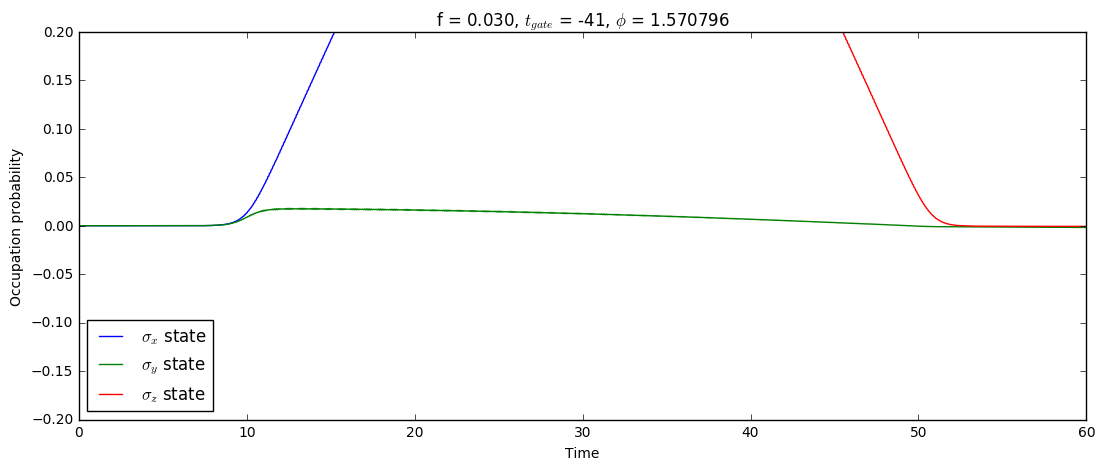

In [100]:
model.plot([-0.2,0.2])

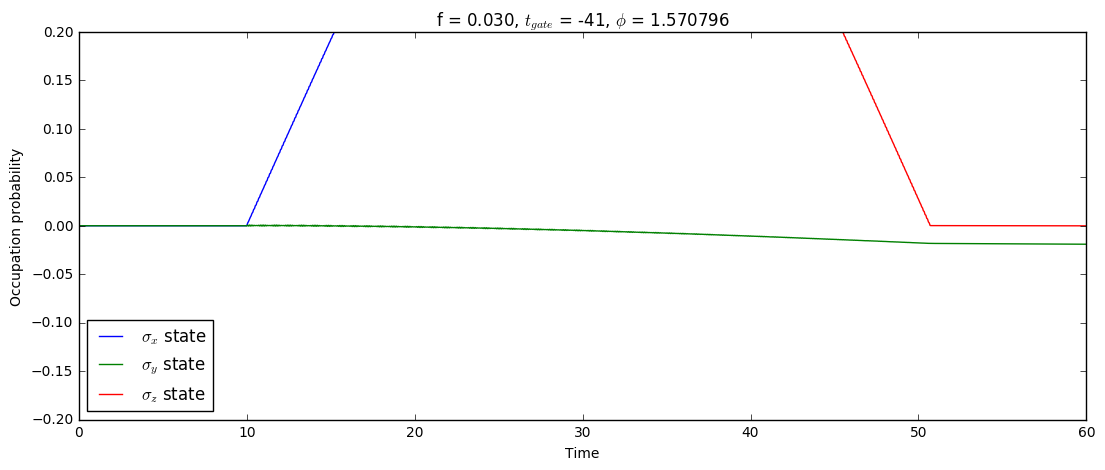

In [94]:
model.plot([-0.2,0.2])

In [192]:
identity(10).data.toarray()[1][1]

(1+0j)